In [153]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [154]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str


graph_builder = StateGraph(AgentState)

In [155]:
def retrieve(state: AgentState):
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

In [156]:
from langchain_openai import ChatOpenAI

generate_llm = ChatOpenAI(model="gpt-4o", max_tokens=100)

In [157]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState):
    context = state["context"]
    query = state["query"]
    rag_chain = generate_prompt | generate_llm 
    response = rag_chain.invoke({"context": context, "question": query})
    print(f"generate response: {response}")
    return {"answer": response.content}

/Users/kimjangho/Desktop/langgraph-agent/.venv/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [158]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [159]:
from langchain import hub
from typing import Literal

relevence_doc_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_relevence_doc(state: AgentState) -> Literal["relevant", "irrelevant"]:
    query = state["query"]
    context = state["context"]
    relevence_chain  = relevence_doc_prompt | llm 
    response = relevence_chain.invoke({"documents": context, "question": query})
    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelevant'


/Users/kimjangho/Desktop/langgraph-agent/.venv/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [160]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(
"""
사용자의 질문을 보고, 우리의 사전을 참고하여 사용자의 질문을 변경해주세요.
사전 : {dictionary}
사용자의 질문 : {{query}}
"""
)

def rewrite(state: AgentState):
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    
    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

In [161]:
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

hallucination_llm = ChatOpenAI(model="gpt-4o", temperature=0)

hallucination_prompt = PromptTemplate.from_template(
"""
you are a teacher tasked with checking if a student's answer is based on the given documents or not.
Given the student's answer and the documents, please determine if the student's answer is based on the documents or not.
if the student's answer is not based on the documents, please return 'hallucinated'
if the student's answer is based on the documents, please return 'not hallucinated'

documents : {documents}
student_answer : {student_answer}
"""
)

def check_hallucination(state: AgentState) -> Literal["hallucinated", "not hallucinated"]:
    answer = state["answer"]
    context = state["context"]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({"student_answer": answer, "documents": context})
    return response


In [162]:
from langchain import hub

helpfullness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState):
    query = state["query"]
    answer = state["answer"]
    helpfullness_chain = helpfullness_prompt | llm
    response = helpfullness_chain.invoke({"question": query, "student_answer": answer})
    if response['Score'] == 1:
        return 'helpful'
    else:
        return 'unhelpful'

def check_helpfulness(state: AgentState):
    return state


/Users/kimjangho/Desktop/langgraph-agent/.venv/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [163]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("check_helpfulness", check_helpfulness)

In [164]:
from langgraph.graph import START, END

# 노드 연결
graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges("retrieve", check_relevence_doc, {
  "relevant": "generate",
  "irrelevant": END
})
graph_builder.add_conditional_edges("generate", check_hallucination, {
  "hallucinated": "generate",
  "not hallucinated": "check_helpfulness"
})
graph_builder.add_conditional_edges("check_helpfulness", check_helpfulness_grader, {
  "helpful": END,
  "unhelpful": "rewrite"
})
graph_builder.add_edge("rewrite", "retrieve")

In [165]:
# 그래프 컴파일
graph = graph_builder.compile()

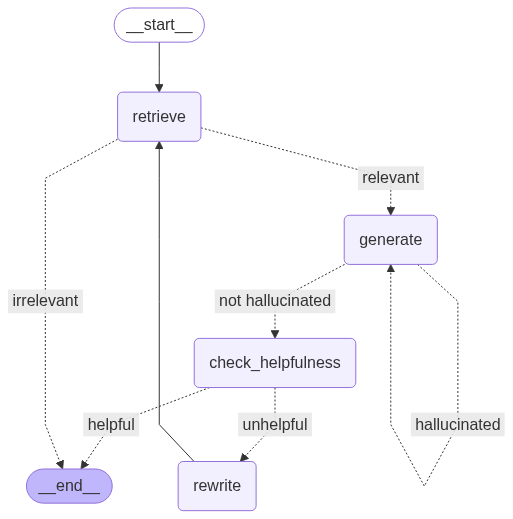

In [166]:
from IPython.display import Image, display

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [167]:
inital_state = {'query': '연봉이 5천만원인 거주자가 납부해야하는 소득세는 얼마인가요?'}
graph.invoke(inital_state)

generate response: content='연봉이 5천만원인 거주자가 납부해야 하는 소득세는 840만원입니다. 이는 과세표준 5천만원 초과 소득에 대한 24% 세율을 반영한 금액입니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 2474, 'total_tokens': 2527, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2432}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BfK6KqKFz0BbQ22NexWdA9VgLEF4m', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--1e6800d2-edb7-4676-b87d-09e048e61309-0' usage_metadata={'input_tokens': 2474, 'output_tokens': 53, 'total_tokens': 2527, 'input_token_details': {'audio': 0, 'cache_read': 2432}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
generate response: content='소득세는 종합소득과세표준에 따라 계산됩니다. 연봉이 5천만원일 경우, 해당 구간의 기본세액인 624만원에 추가적으로 (8,800만원을 초과하는 

{'query': '연봉이 5천만원인 거주자가 납부해야하는 소득세는 얼마인가요?',
 'context': [Document(id='1b1aaf5f-6b84-4176-a226-c2c8e7f0e248', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='30d76fab-2884-47d1-a9da-a55bd1fd2b79', metadata={'source': './documents/income_tax.txt'}, page_content='